In [1]:
# !/usr/bin/python
# -*- coding:utf-8 -*-

import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import warnings


def extend(a, b):
    return 1.05 * a - 0.05 * b, 1.05 * b - 0.05 * a


def data_clean(show):
    y = data['Current']
    idx_time = (data['Time'] > 6.76) & (data['Time'] < 6.91)
    idx_current = (y > 9.31) & (y < 9.33)
    idx = idx_time & idx_current
    data['Current'][idx] += (y[y > 9.34].median() - y[idx].median())

    idx_current = (y > 9.01) & (y < 9.04)
    idx = idx_time & idx_current
    data['Current'][idx] += (y[y < 9.1].median() - y[idx].median())

    if show:
        plt.figure(figsize=(13, 6))
        plt.plot(data['Time'], y, 'r.-', lw=0.2)
        plt.ylim(extend(y.min(), y.max()))
        plt.grid(b=True, ls=':')
        plt.xlabel(u'时间', fontsize=14)
        plt.ylabel(u'电流强度', fontsize=14)
        plt.title(u'原始电流的变化情况', fontsize=16)
        plt.show()

In [5]:
warnings.filterwarnings("ignore")  # hmmlearn(0.2.0) < sklearn(0.18)
pd.set_option('display.width', 100)
np.set_printoptions(edgeitems=100)
from matplotlib.font_manager import FontProperties
font_set = FontProperties(fname='../fonts/simhei.ttf', size=15)
fontproperties=font_set
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

n_components = 3
data = pd.read_excel(io='../dataset/Current.xls', sheetname='Sheet1', header=0)
# data['Current'] = MinMaxScaler().fit_transform(data['Current'])
data['Current'] *= 1e6

# 去除明显的异常值
data_clean(False)

x = data['Time'].reshape(-1, 1)
y = data['Current'].reshape(-1, 1)
model = hmm.GaussianHMM(n_components=n_components, covariance_type='full', n_iter=10)
model.fit(y)
components = model.predict_proba(y)
components_state = model.predict(y)
components_pd = pd.DataFrame(components, columns=np.arange(n_components), index=data.index)
data = pd.concat((data, components_pd), axis=1)
print 'data = \n', data

data = 
         Time  Current             0              1              2
0     0.00677   9.0763  1.212112e-16   1.000000e+00   0.000000e+00
1     0.01269   9.0704  1.766806e-03   9.982332e-01  2.387800e-271
2     0.01665   9.0792  4.149711e-03   9.958503e-01  2.656271e-255
3     0.02069   9.2237  1.000000e+00   5.238277e-82   2.607689e-63
4     0.02465   9.3529  4.302691e-02  3.959308e-291   9.569731e-01
5     0.02865   9.3598  4.804580e-03  8.550485e-307   9.951954e-01
6     0.03278   9.3532  1.688347e-02  2.734746e-292   9.831165e-01
7     0.03669   9.3540  1.457927e-02  5.093359e-294   9.854207e-01
8     0.04074   9.3554  3.327619e-02  3.759744e-296   9.667238e-01
9     0.04465   9.0796  5.785044e-03   9.942150e-01  4.378639e-254
10    0.04878   9.0863  5.216036e-03   9.947840e-01  3.967485e-243
11    0.05270   9.0810  2.249713e-03   9.977503e-01  1.417578e-252
12    0.05823   9.0752  4.410614e-03   9.955894e-01  6.582827e-262
13    0.06068   9.3509  9.183838e-02  2.759216e-286   

整流后均值： 9.2232277


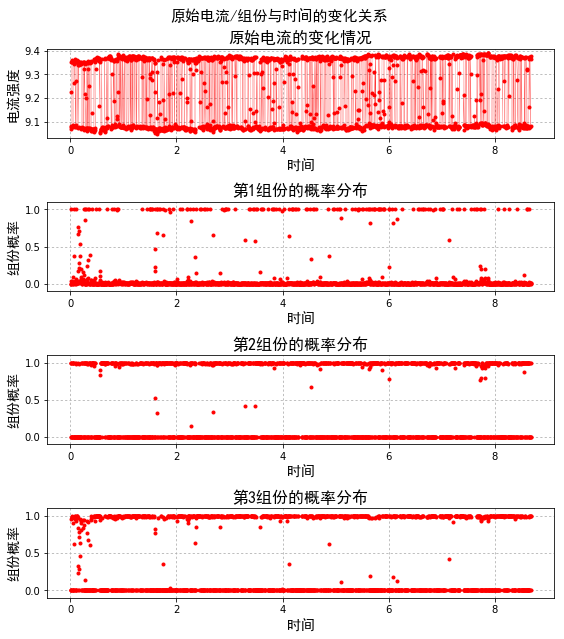

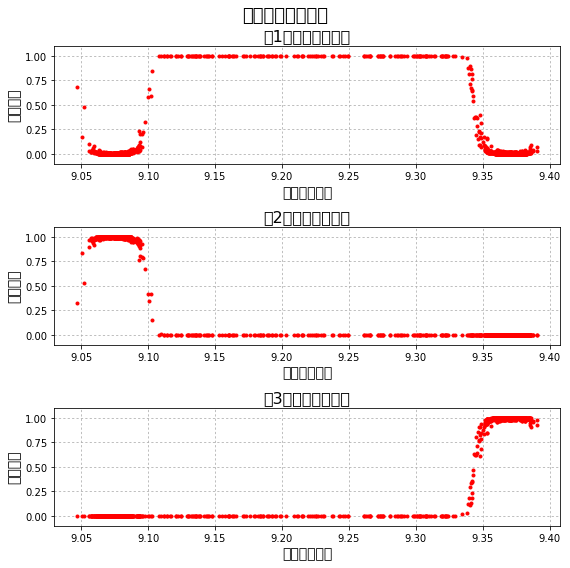

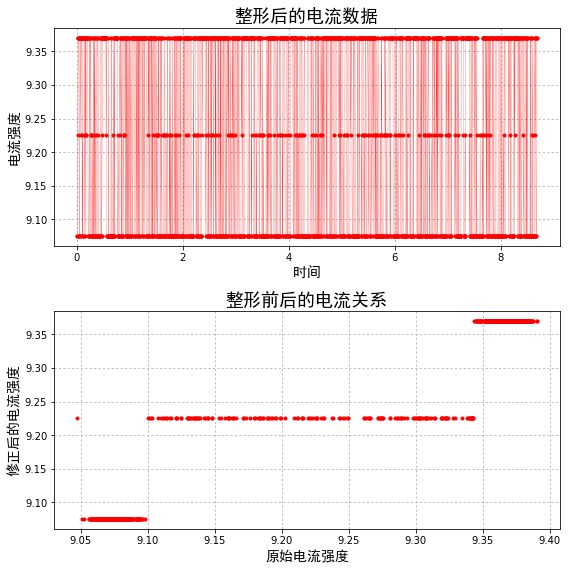

In [6]:
plt.figure(num=1, facecolor='w', figsize=(8, 9))
plt.subplot(n_components + 1, 1, 1)
plt.plot(x, y, 'r.-', lw=0.2)
plt.ylim(extend(y.min(), y.max()))
plt.grid(b=True, ls=':')
plt.xlabel(u'时间', fontsize=14, fontproperties=fontproperties)
plt.ylabel(u'电流强度', fontsize=14, fontproperties=fontproperties)
plt.title(u'原始电流的变化情况', fontsize=16, fontproperties=fontproperties)
for component in np.arange(n_components):
    plt.subplot(n_components + 1, 1, component + 2)
    plt.plot(x, data[component], 'r.')
    plt.ylim((-0.1, 1.1))
    plt.grid(b=True, ls=':')
    plt.ylabel(u'组份概率', fontsize=14, fontproperties=fontproperties)
    plt.xlabel(u'时间', fontsize=14, fontproperties=fontproperties)
    plt.title(u'第%d组份的概率分布' % (component + 1), fontsize=16, fontproperties=fontproperties)
plt.suptitle(u'原始电流/组份与时间的变化关系', fontsize=18, fontproperties=fontproperties)
plt.tight_layout(pad=1, rect=(0, 0, 1, 0.96))
# plt.savefig('1.png')

plt.figure(num=2, facecolor='w', figsize=(8, 8))
for component in np.arange(n_components):
    plt.subplot(n_components, 1, component + 1)
    plt.plot(y, data[component], 'r.')
    plt.xlim(extend(y.min(), y.max()))
    plt.ylim((-0.1, 1.1))
    plt.grid(b=True, ls=':')
    plt.xlabel(u'原始电流强度', fontsize=14)
    plt.ylabel(u'组份概率', fontsize=14)
    plt.title(u'第%d组份的概率分布' % (component + 1), fontsize=16)
plt.suptitle(u'各组份的概率分布', fontsize=18)
plt.tight_layout(pad=1, rect=(0, 0, 1, 0.96))
# plt.savefig('2.png')

y_new = np.zeros_like(data['Current'])
for component in np.arange(n_components):
    idx = components_state == component
    y_new[idx] = np.median(y[idx])
print u'整流后均值：', np.mean(y_new)
data['New'] = y_new
data.to_excel('new_current.xls', index=False)

plt.figure(num=3, facecolor='w', figsize=(8, 8))
plt.subplot(211)
plt.plot(x, y_new, 'r.-', lw=0.2)
plt.ylim(extend(y_new.min(), y_new.max()))
plt.grid(b=True, ls=':')
plt.xlabel(u'时间', fontsize=14, fontproperties=fontproperties)
plt.ylabel(u'电流强度', fontsize=14, fontproperties=fontproperties)
plt.title(u'整形后的电流数据', fontsize=18, fontproperties=fontproperties)
plt.subplot(212)
plt.plot(data['Current'], data['New'], 'r.')
plt.ylim(extend(data['New'].min(), data['New'].max()))
plt.grid(b=True, ls=':')
plt.xlabel(u'原始电流强度', fontsize=14, fontproperties=fontproperties)
plt.ylabel(u'修正后的电流强度', fontsize=14, fontproperties=fontproperties)
plt.title(u'整形前后的电流关系', fontsize=18, fontproperties=fontproperties)
plt.tight_layout(pad=1, rect=(0, 0, 1, 1))
# plt.savefig('3.png')

plt.show()